# LHb data, cell number 91 (19 in the new numbering)

In [1]:
import pyabf  # Load pyABF
import matplotlib.pyplot as plt
%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns

In [2]:
file_path_91 = "../lhb_bursting/cell91basal.abf"  # we select the abf record file
abf = pyabf.ABF(file_path_91)              # we load it
print(abf)                                 # record characteristics 

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 9 sweeps, having no tags, with a total length of 3.58 minutes, recorded without a protocol file.


In [3]:
methods = [method for method in dir(abf) if callable(getattr(abf, method)) and not method.startswith("__")]
print("\n".join(methods))

_dtype
_getAdcNameAndUnits
_getDacNameAndUnits
_ide_helper
_loadAndScaleData
_makeAdditionalVariables
_readHeadersV1
_readHeadersV2
getAllXs
getAllYs
headerLaunch
launchInClampFit
saveABF1
setSweep
sweepD


In [4]:
# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

      Voltage Trace (mV): [-70.613 -70.238 -70.394 ... -75.679 -75.648 -75.616]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]


In [5]:
# Choose a specific sweep (e.g., first sweep -> index 0)  
sweep_index = 0  
abf.setSweep(sweep_index)  

# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

# Check all available ADC channels (recorded signals)
print(f"{'Recorded Channels:':>25} {abf.adcNames}")

# Check DAC channels (command input signals)
print(f"{'Command Channels:':>25} {abf.dacNames}")

      Voltage Trace (mV): [-70.613 -70.238 -70.394 ... -75.679 -75.648 -75.616]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]
       Recorded Channels: ['Waveform']
        Command Channels: ['AO #0']



Voltage Trace Statistics:
           Mean (mV): -77.104
         Median (mV): -77.555
            Min (mV): -82.121
            Max (mV): 38.309
        Std Dev (mV): 2.961
          Range (mV): 120.430


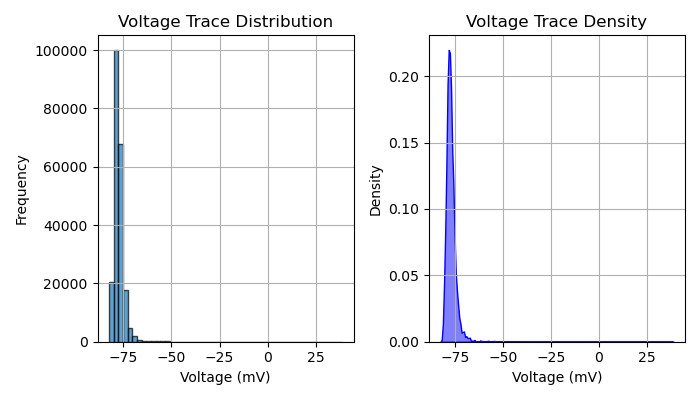

In [6]:
data = abf.sweepY  # The voltage trace

stats = {
    "Mean (mV)"   : np.mean(data),
    "Median (mV)" : np.median(data),
    "Min (mV)"    : np.min(data),
    "Max (mV)"    : np.max(data),
    "Std Dev (mV)": np.std(data),
    "Range (mV)"  : np.ptp(data),  # Max - Min
}

print("\nVoltage Trace Statistics:")
for key, value in stats.items():
    print(f"{key:>20}: {value:.3f}")


# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot histogram on the first subplot
axes[0].hist(data, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Voltage (mV)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Voltage Trace Distribution")
axes[0].grid(True)

# Plot KDE on the second subplot
sns.kdeplot(data, bw_adjust=0.5, fill=True, color="b", alpha=0.5, ax=axes[1])
axes[1].set_xlabel("Voltage (mV)")
axes[1].set_ylabel("Density")
axes[1].set_title("Voltage Trace Density")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

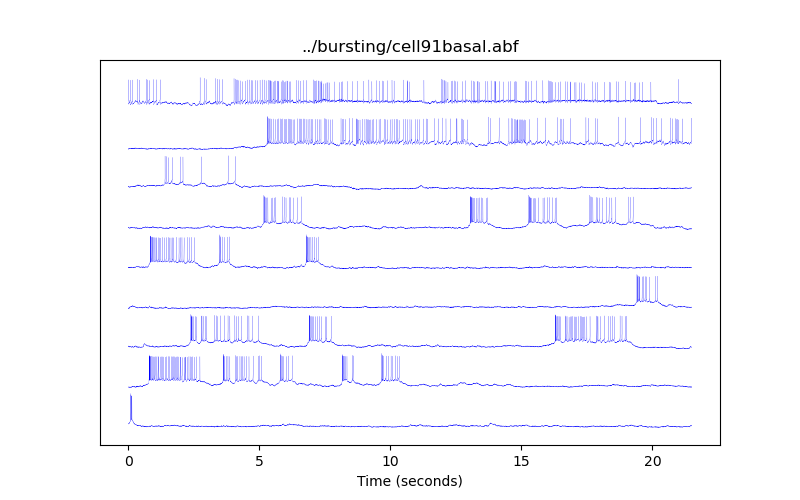

In [7]:
def plot_abf():
    plt.figure(figsize=(8, 5))

    # Plot every sweep with vertical offset
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140 * sweepNumber
        plt.plot(abf.sweepX, abf.sweepY + offset, color='b', lw=0.1)  # Recorded voltage
        #plt.plot(abf.sweepX, abf.sweepC + offset, color='r', lw=0.5)  # Command waveform in red

    # Decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # Hide Y axis
    plt.title(file_path_91)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

plot_abf()

In [8]:
# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)
 
# Lowpass Bessel filter
b_lowpass, a_lowpass = signal.bessel(4,     # Order of the filter
                                     2000,  # Cutoff frequency
                                     'low', # Type of filter
                                     analog=False,  # Analog or digital filter
                                     norm='phase',  # Critical frequency normalization
                                     fs=fs)  # fs: sampling frequency
 
signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, abf.sweepY)

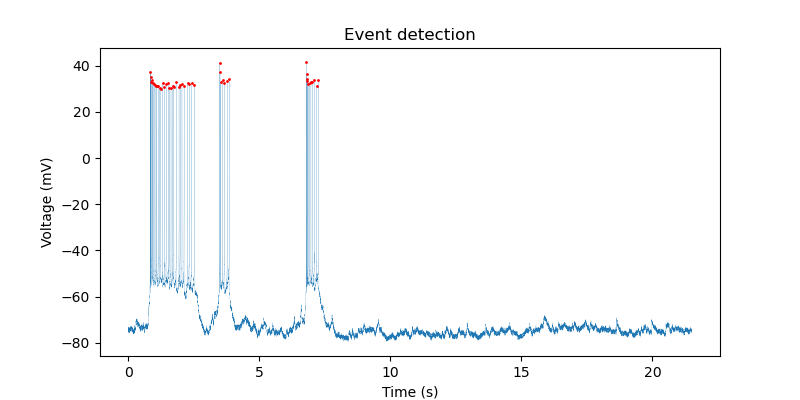

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,8512,0.8512,inf,0.0000,0.551660,0.205180,0.346480,37.369999,113.736996
1,2,8652,0.8652,71.428571,0.0140,0.533523,0.179913,0.353611,35.275002,91.315002
2,3,8826,0.8826,57.471264,0.0174,0.624057,0.197920,0.426137,32.772999,87.062000
3,4,9096,0.9096,37.037037,0.0270,0.655709,0.192466,0.463243,33.680000,89.032001
4,5,9349,0.9349,39.525692,0.0253,0.672938,0.219067,0.453871,32.460999,85.060997
5,6,9715,0.9715,27.322404,0.0366,0.719402,0.209712,0.509690,32.117001,85.779999
6,7,10188,1.0188,21.141649,0.0473,0.640510,0.220831,0.419679,31.773001,87.281000
7,8,10599,1.0599,24.330900,0.0411,0.673918,0.255191,0.418727,31.115999,84.059999
8,9,10949,1.0949,28.571429,0.0350,0.750423,0.263654,0.486768,31.365999,86.436998
9,10,11494,1.1494,18.348624,0.0545,0.677390,0.260021,0.417368,31.429001,86.844002


In [10]:
# Assign the variables here to simplify the code
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered
abf.setSweep(4)

# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -40.0                  # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.4 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

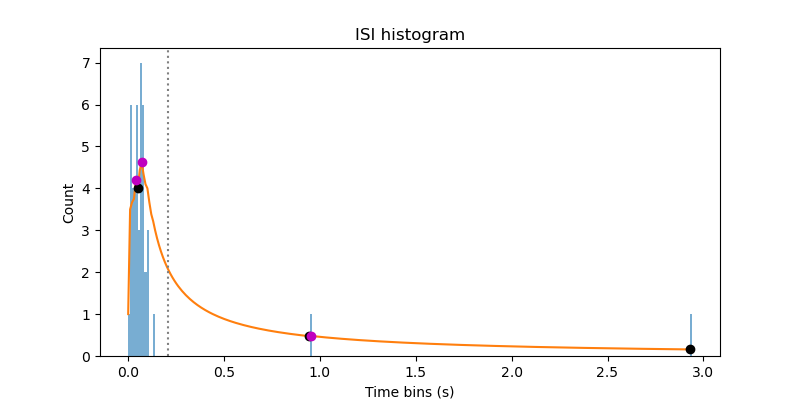

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.136349,0.0558,38.208807,6.078894,0.21,0.94,0.04


In [11]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

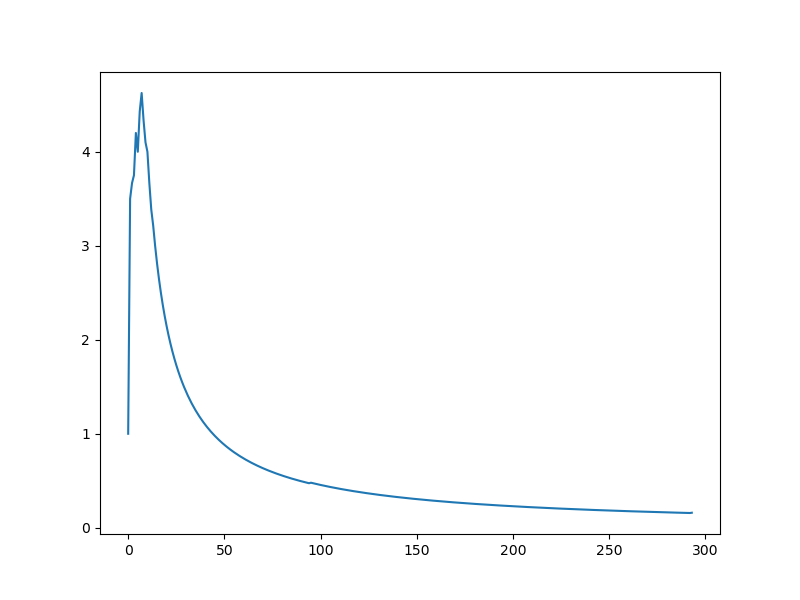

In [12]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
mycum = np.cumsum(hist_counts)  # Cumulative sum
mycma = mycum / np.arange(1, len(mycum) + 1)

plt.figure(figsize=(8, 6))
plt.plot(mycma)
plt.show()

In [15]:
abf = pyabf.ABF(file_path_91)
abf.setSweep(4)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes using a threshold or peak detection
threshold = -30.0  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)

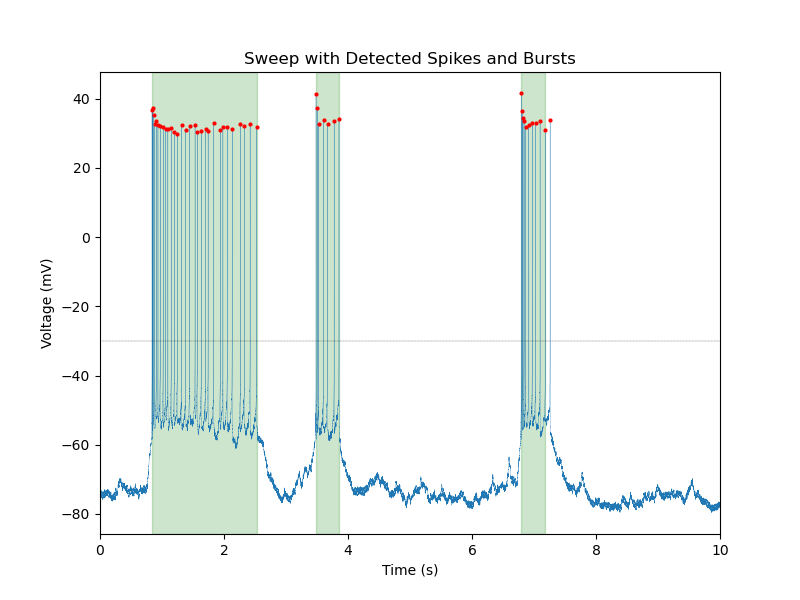

In [16]:
# Detect spikes
threshold = -30.0  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.5  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
plt.xlim((0,10))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

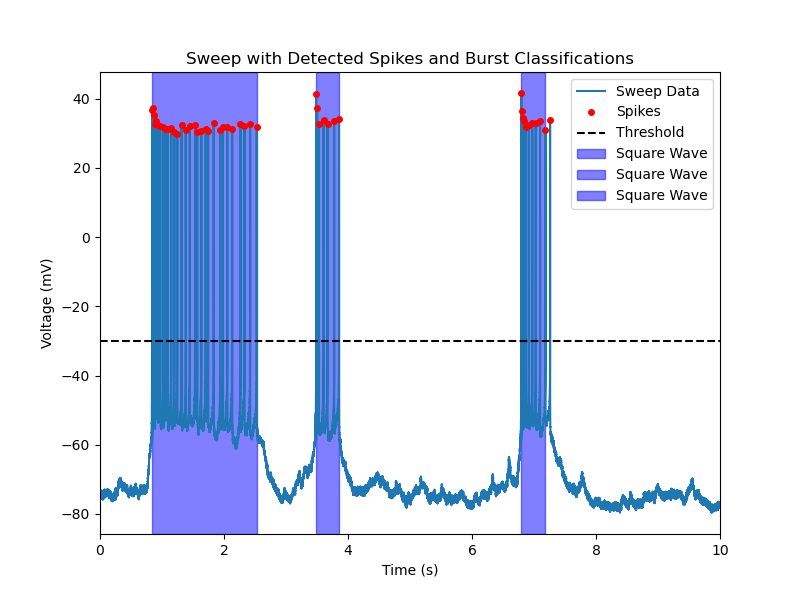

Square Wave Bursts:
  Burst 1: Start = 0.840 s, End = 2.527 s
  Burst 2: Start = 3.485 s, End = 3.855 s
  Burst 3: Start = 6.795 s, End = 7.185 s

Parabolic Bursts:

Other Bursts:


In [17]:
# Initialize lists for categorized bursts
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the minimum voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.min(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison
    #curr_start = bursts[i][0]
    #bef_curr_burst_mask = (time > curr_start-1) & (time < curr_start)
    #prev_mean_voltage = np.mean(voltage[bef_curr_burst_mask])
        
    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('nan')  # No next interval, ignore in comparison
    #curr_end = bursts[i][1]
    #aft_curr_burst_mask = (time > curr_end) & (time < curr_end+1)
    #next_mean_voltage = np.mean(voltage[aft_curr_burst_mask])
        
    # Calculate overall inter-burst mean voltage
    inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

    # Test conditions to classify the burst
    if burst_min_voltage > inter_burst_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min_voltage < inter_burst_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# Plot the sweep with classified bursts highlighted
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts with a single legend entry per category
square_wave_patch = None
parabolic_patch = None
other_patch = None

for burst_start, burst_end in square_wave_bursts:
    square_wave_patch = plt.axvspan(burst_start, burst_end, color='blue', alpha=0.5, label='Square Wave')

for burst_start, burst_end in parabolic_bursts:
    parabolic_patch = plt.axvspan(burst_start, burst_end, color='green', alpha=0.5, label='Parabolic')

for burst_start, burst_end in other_bursts:
    other_patch = plt.axvspan(burst_start, burst_end, color='orange', alpha=0.5, label='Other')

# Filter out None handles
#handles = [patch for patch in [square_wave_patch, parabolic_patch, other_patch] if patch is not None]
#labels = ['Square Wave', 'Parabolic', 'Other'][:len(handles)]

# Add a single legend entry for each classification
#plt.legend(handles, labels)

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Burst Classifications")
plt.xlim((0,10))
plt.legend()
plt.show()

# Print results
print("Square Wave Bursts:")
for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nParabolic Bursts:")
for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nOther Bursts:")
for i, (burst_start, burst_end) in enumerate(other_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")
